In [1]:
import sys, os
import sparse
import xsimlab as xs
import xarray as xr
import numpy as np
import pandas as pd
import igraph as ig
from pgljupyter import SceneWidget

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab
from vmlab.models.vmango import vmango as model
from vmlab.enums import Nature

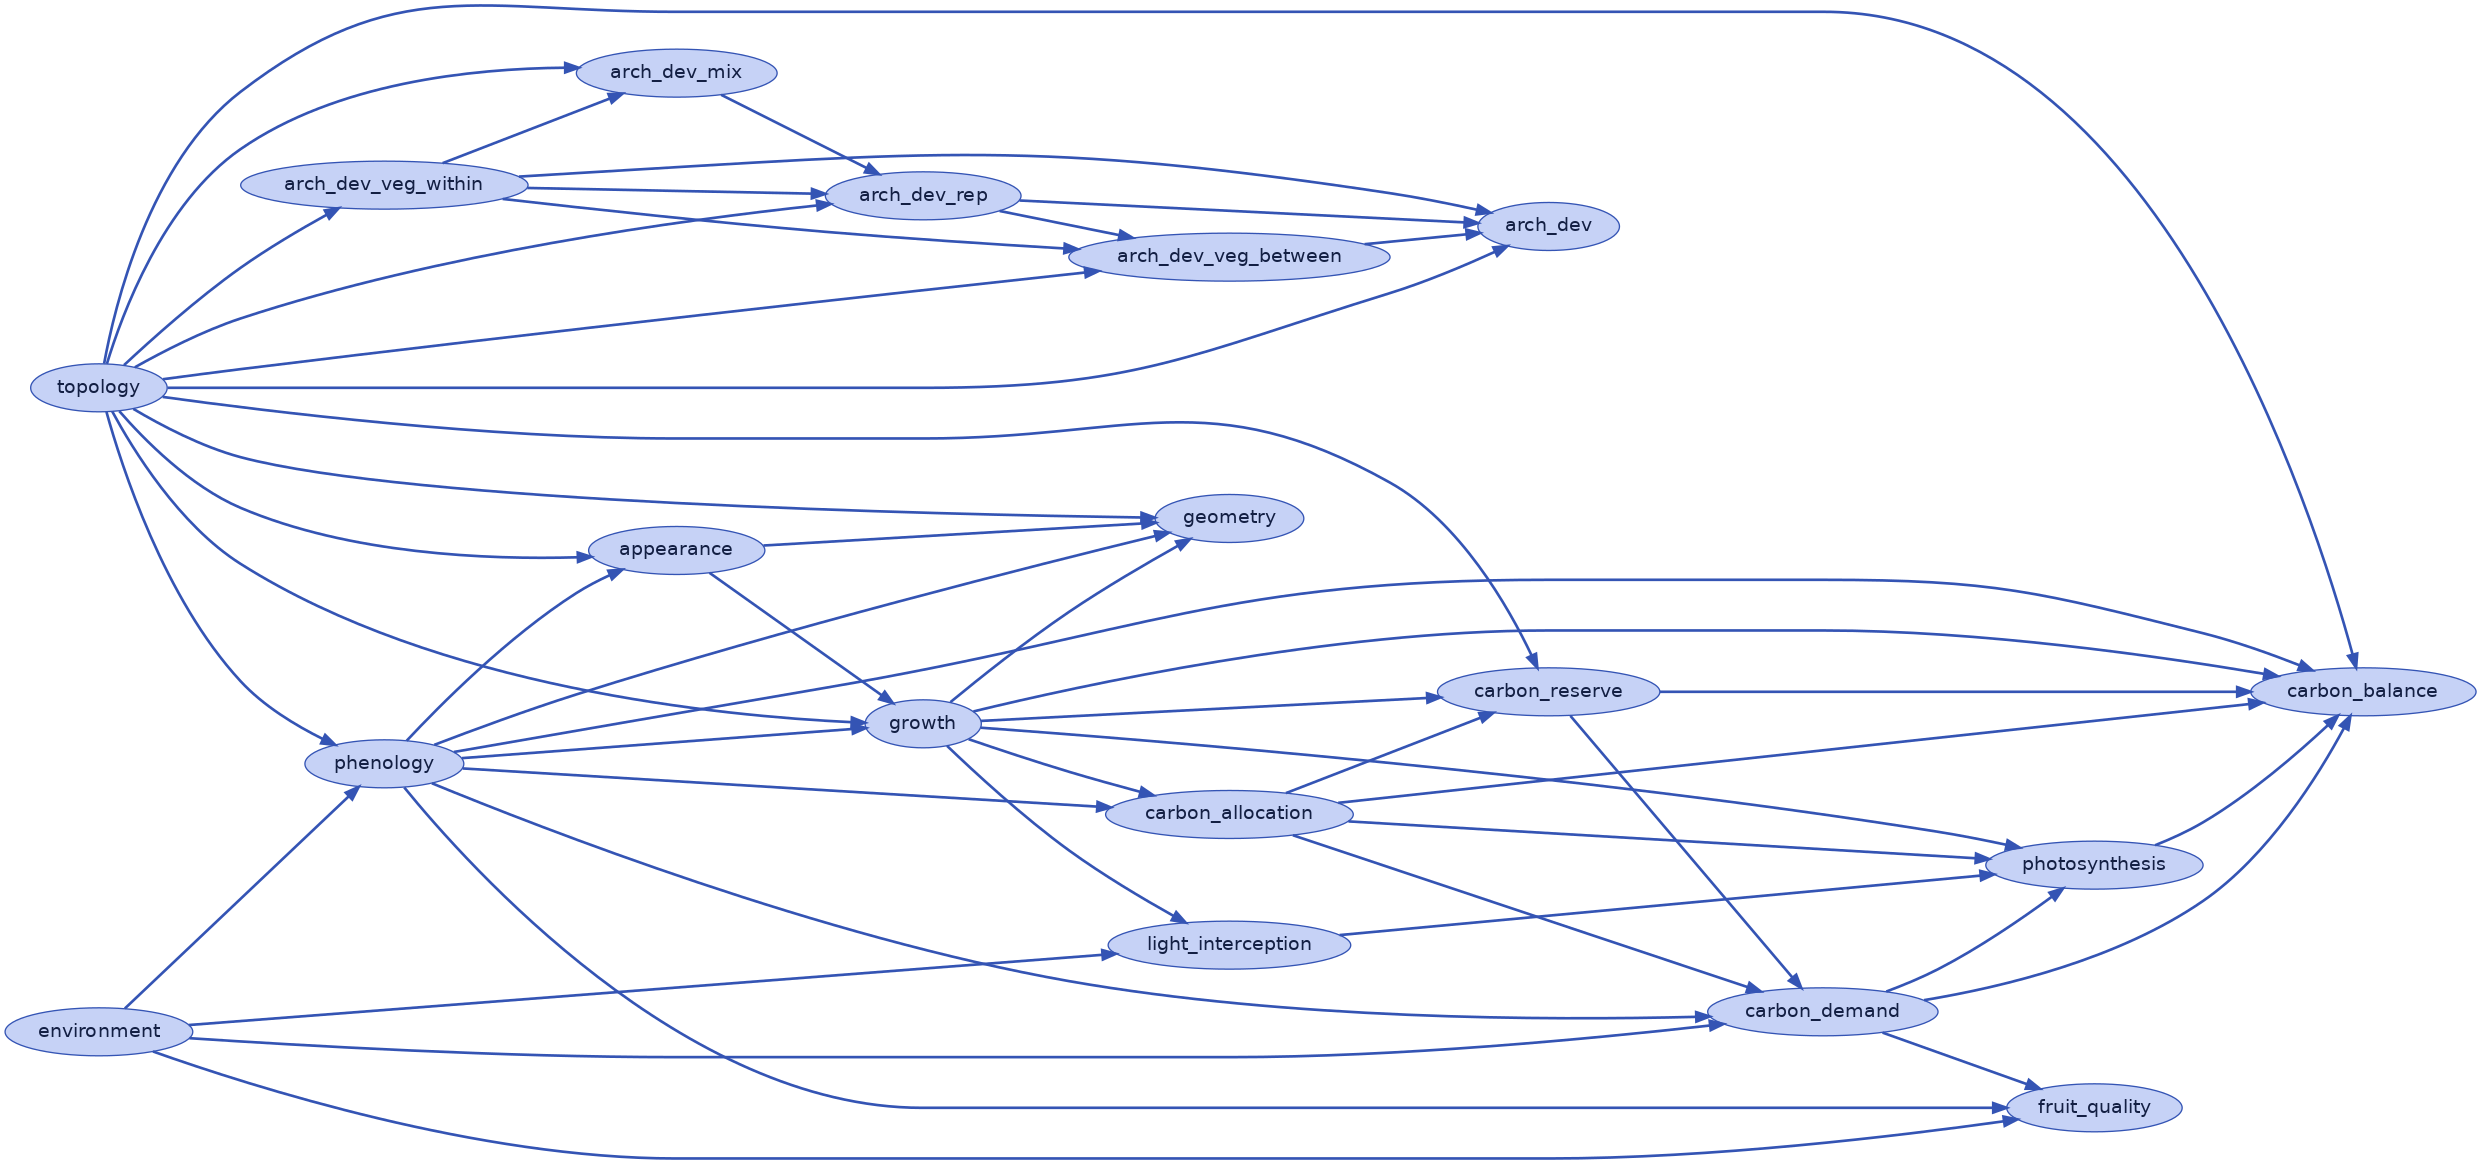

In [3]:
model.visualize()

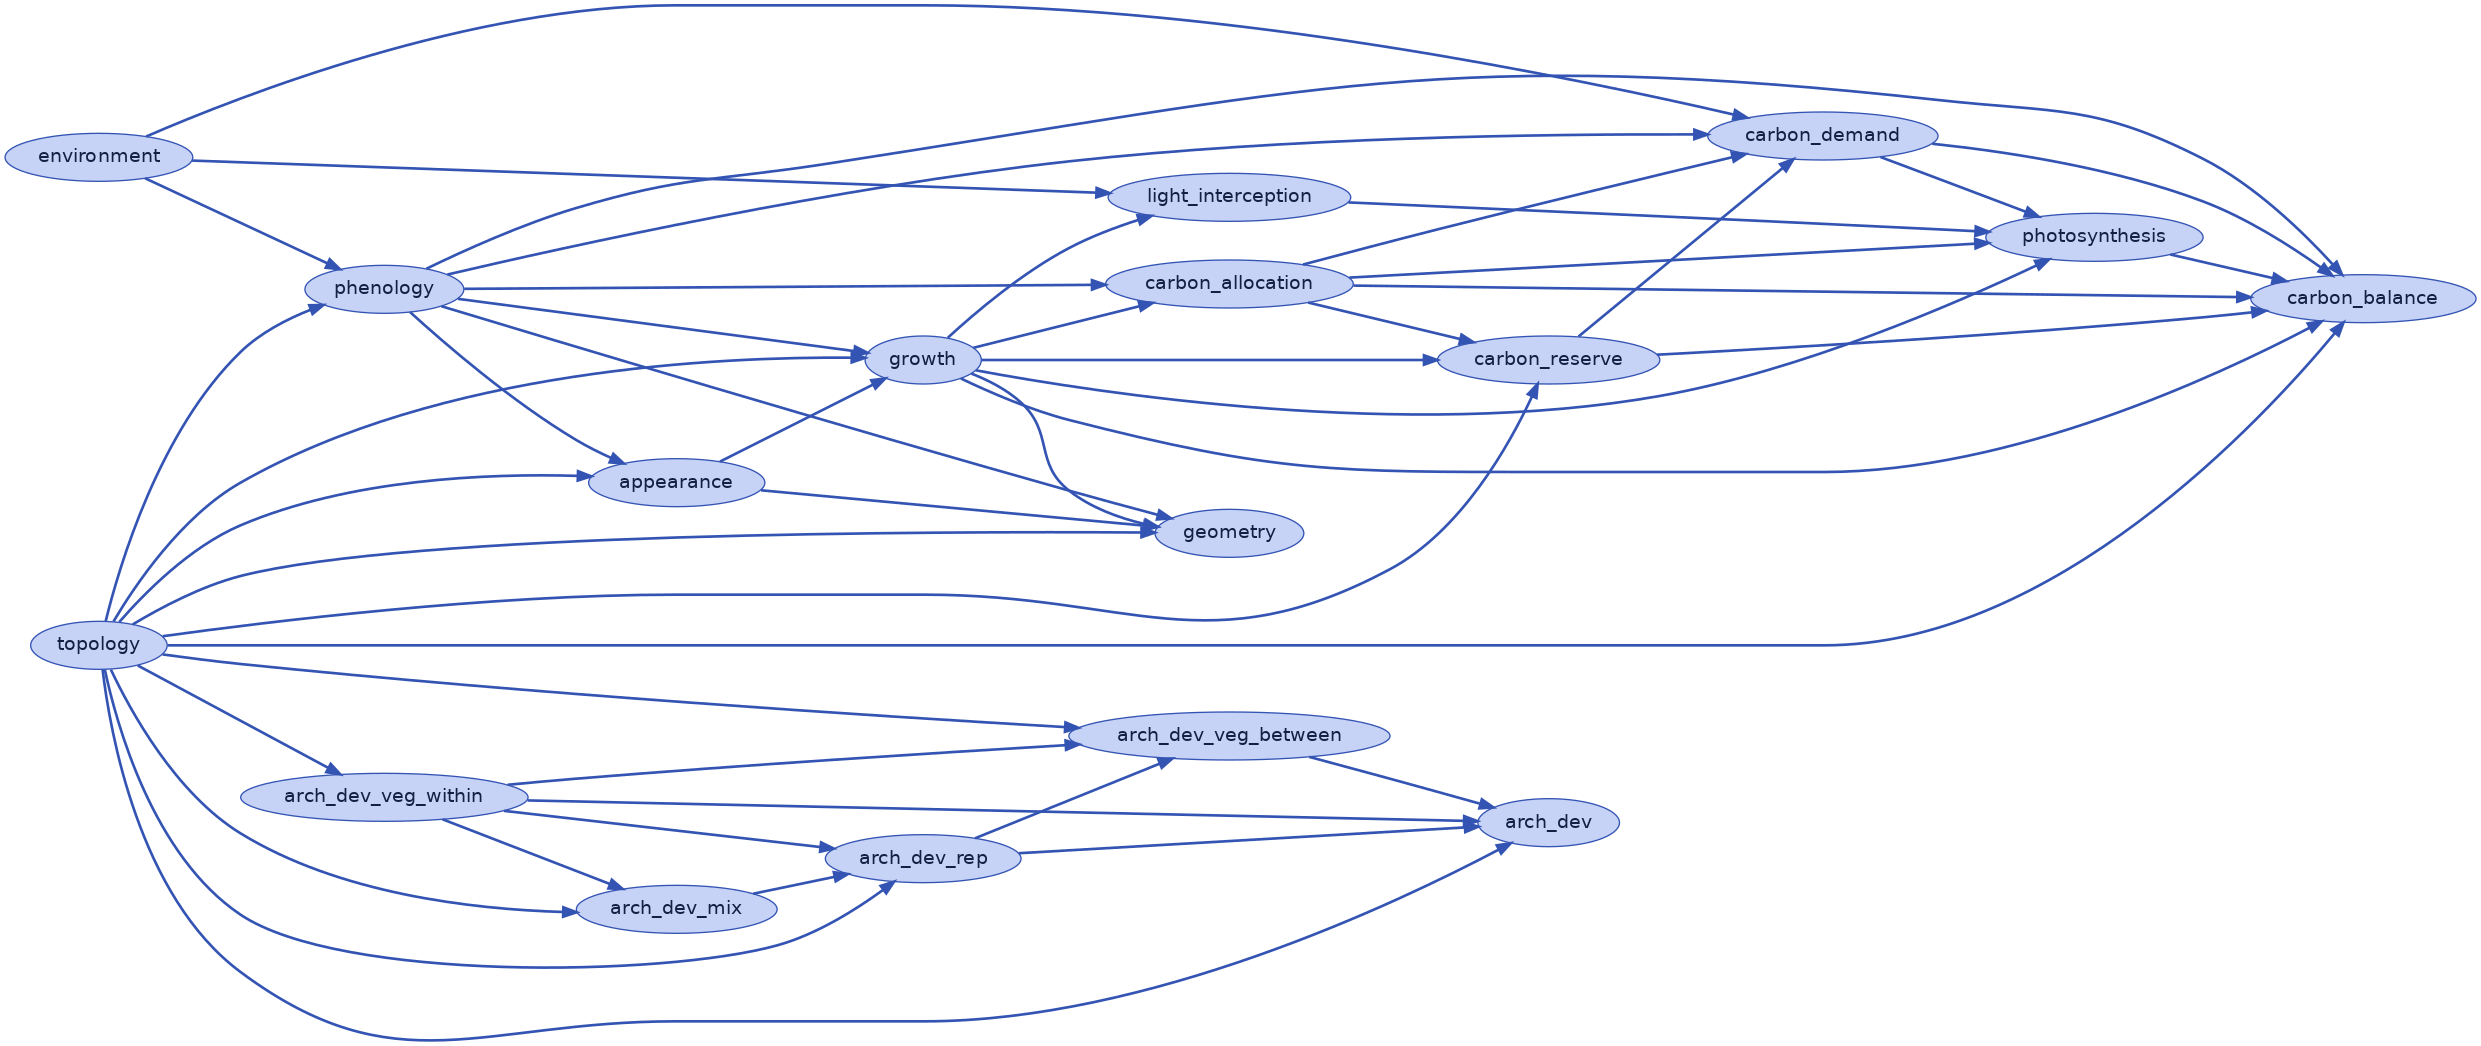

In [4]:
#model = model.drop_processes(['light_interception', 'carbon_allocation', 'photosynthesis', 'carbon_reserves', 'carbon_demand', 'carbon_balance', 'fruit_quality'])
model = model.drop_processes(['fruit_quality'])
model.visualize()

In [5]:
tree = pd.DataFrame({
    'id': [0, 1],
    'parent_id': [np.nan, 0],
    'cycle': [3, 3],
    'is_apical': [1, 1],
    'appearance_month': [3, 3],
    'ancestor_nature': [0, 0],
    'ancestor_is_apical': [1, 1]
})
tree

,id,parent_id,cycle,is_apical,appearance_month,ancestor_nature,ancestor_is_apical
0,0,NaN,3,1,3,0,1
1,1,0.0,3,1,3,0,1


In [6]:
ds = vmlab.create_setup(
    model,
    initial_tree_df=tree,
    start_date='2002-04-01',
    end_date='2004-12-31',
    setup_toml='../share/setup/vmango.toml',
    current_cycle=3,
    input_vars={
        'topology': {
            'seed': 0,
            'month_begin_veg_cycle': 7,
            'doy_begin_flowering': 214
        },
        'geometry__interpretation_freq': 3
    },
    output_vars='day'
)

In [7]:
sw = SceneWidget(size_world=2.5)
sw

SceneWidget(scenes=[{'id': 'VKqBrDKFQpH0JqDLezhjoA0pE', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

In [8]:
scene_ = None
@xs.runtime_hook(stage='run_step')
def hook(model, context, state):
    global scene_
    scene = state[('geometry', 'scene')]
    if scene != scene_:
        sw.set_scenes([scene], scales=[1/100])
        scene_ = scene
    
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[xs.monitoring.ProgressBar(), hook])
ds_out

             0% | initialize 

<xarray.Dataset>
Dimensions:                                             (GU: 25, day: 1006, hour: 24)
Coordinates:
  * GU                                                  (GU) <U10 'GU0' ... '...
  * day                                                 (day) datetime64[ns] ...
  * hour                                                (hour) int8 0 1 ... 23
Data variables: (12/135)
    appearance__appeared                                (day, GU) float32 1.0...
    appearance__final_length_gu                         (day, GU) float32 13....
    appearance__final_length_inflos                     (day, GU) object None...
    appearance__final_length_internodes                 (day, GU) object [1.3...
    appearance__final_length_leaves                     (day, GU) object [19....
    appearance__nb_internode                            (day, GU) float32 13....
    ...                                                  ...
    topology__month_begin_veg_cycle                     int64 7
    topology__nb_descendants                            (day, GU) int64 1 ... 0
    topology__nb_gu                                     int64 25
    topology__parent_is_apical                          (day, GU) float32 1.0...
    topology__seed                                      int64 0
    topology__sim_start_date                            datetime64[D] 2002-04-01

<AxesSubplot:xlabel='topology__appearance_date'>

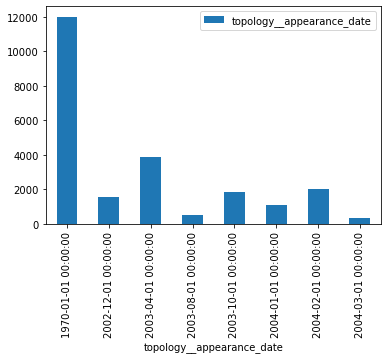

In [9]:
appearance_date = ds_out.topology__appearance_date.groupby(ds_out.topology__appearance_date)
appearance_date.count().to_dataframe().plot.bar()

<AxesSubplot:xlabel='arch_dev__pot_burst_date'>

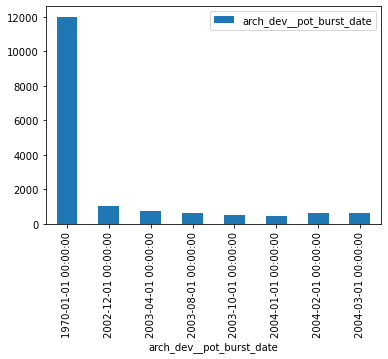

In [10]:
pot_burst_date = ds_out.arch_dev__pot_burst_date.groupby(ds_out.arch_dev__pot_burst_date)
pot_burst_date.count().to_dataframe().plot.bar()

<AxesSubplot:xlabel='arch_dev__pot_flowering_date'>

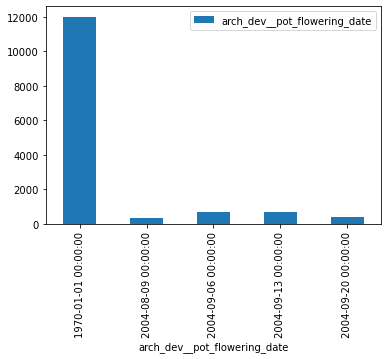

In [11]:
pot_flowering_date = ds_out.arch_dev__pot_flowering_date.groupby(ds_out.arch_dev__pot_flowering_date)
pot_flowering_date.count().to_dataframe().plot.bar()

<AxesSubplot:xlabel='phenology__nb_inflo'>

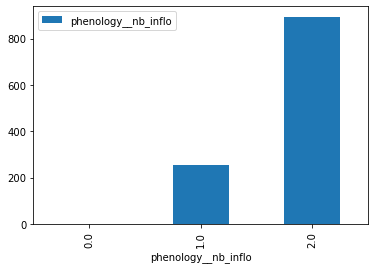

In [13]:
topology__nb_inflo = ds_out.phenology__nb_inflo.groupby(ds_out.phenology__nb_inflo)
topology__nb_inflo.sum().to_dataframe().plot.bar()

<AxesSubplot:xlabel='phenology__nb_fruit'>

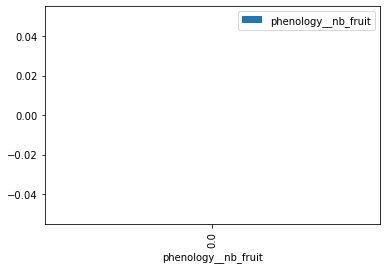

In [15]:
nb_fruit = ds_out.phenology__nb_fruit.groupby(ds_out.phenology__nb_fruit)
nb_fruit.sum().to_dataframe().plot.bar()

In [16]:
# nb_children = xr.DataArray(ds_out.arch_dev__pot_has_apical_child + ds_out.arch_dev__pot_nb_lateral_children, name='nb_children')
# nb_children = nb_children[nb_children > 0]
# nb_children.groupby(nb_children).count().to_dataframe().plot.bar()

IndexError: 2-dimensional boolean indexing is not supported. 

In [35]:
# nb_children = xr.DataArray(ds_out.arch_dev__pot_has_apical_child + ds_out.arch_dev__pot_nb_lateral_children, name='nb_children')
# ds_children = xr.Dataset({
#     'nb_children':  nb_children[nb_children > 0], 
#     'cycle': ds_out.topology__cycle[nb_children > 0]
# })
# ds_children

IndexError: 2-dimensional boolean indexing is not supported. 

In [ ]:
# ds_children.groupby(ds_children.cycle).sum().to_dataframe().plot.bar()

In [ ]:
# ds_out.appearance__final_length_inflos.values.tolist()

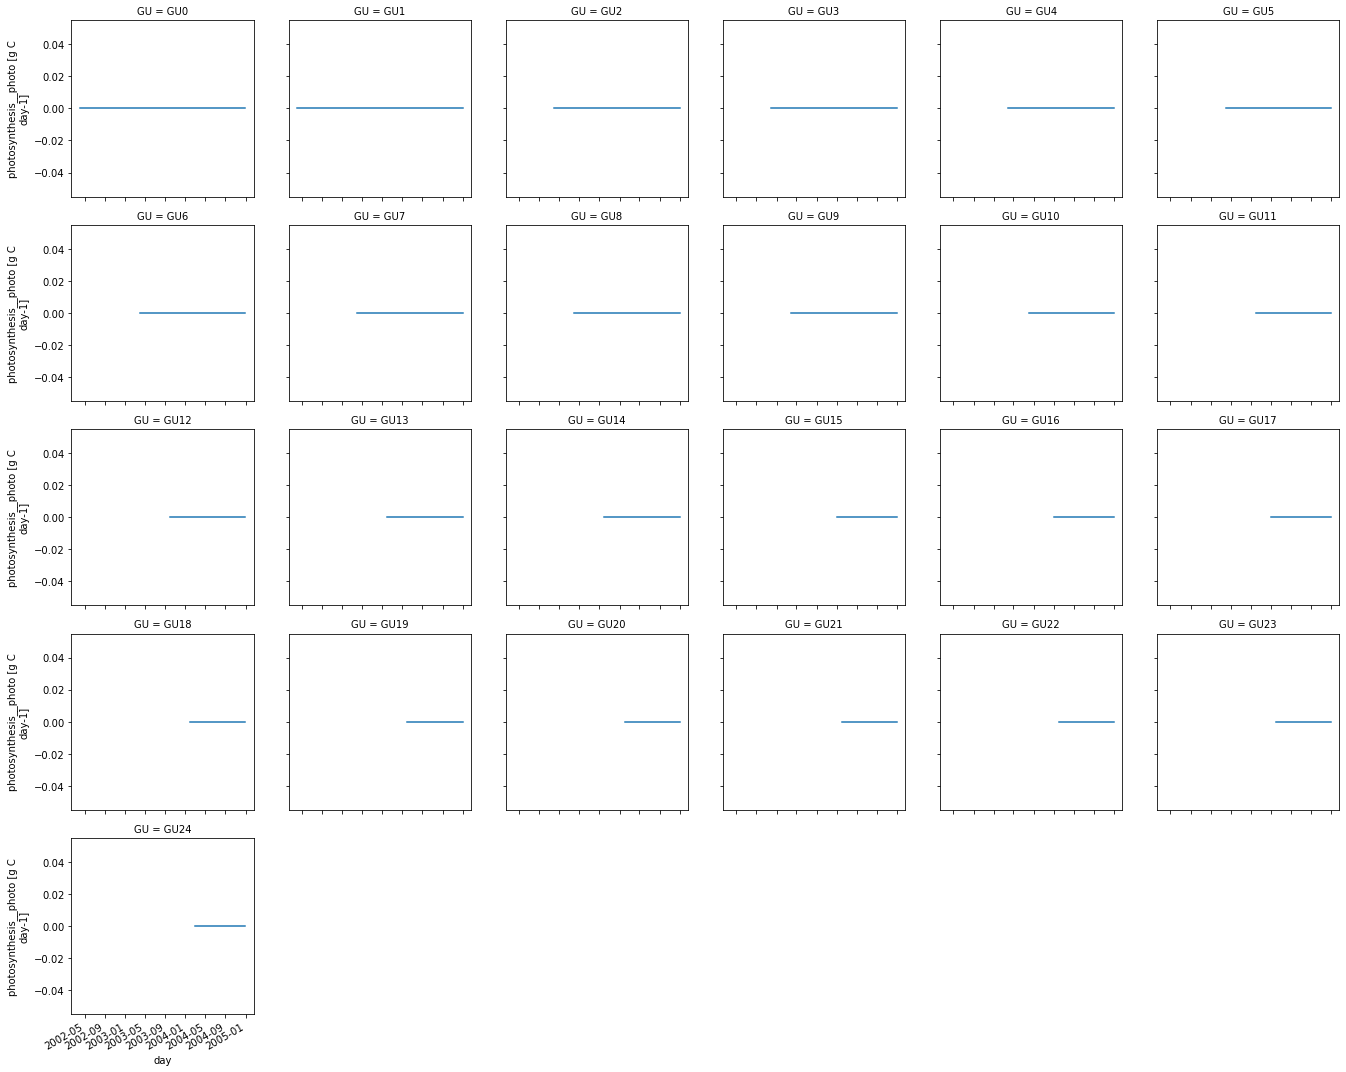

In [32]:
ds_out.photosynthesis__photo.plot(col='GU', col_wrap=6)

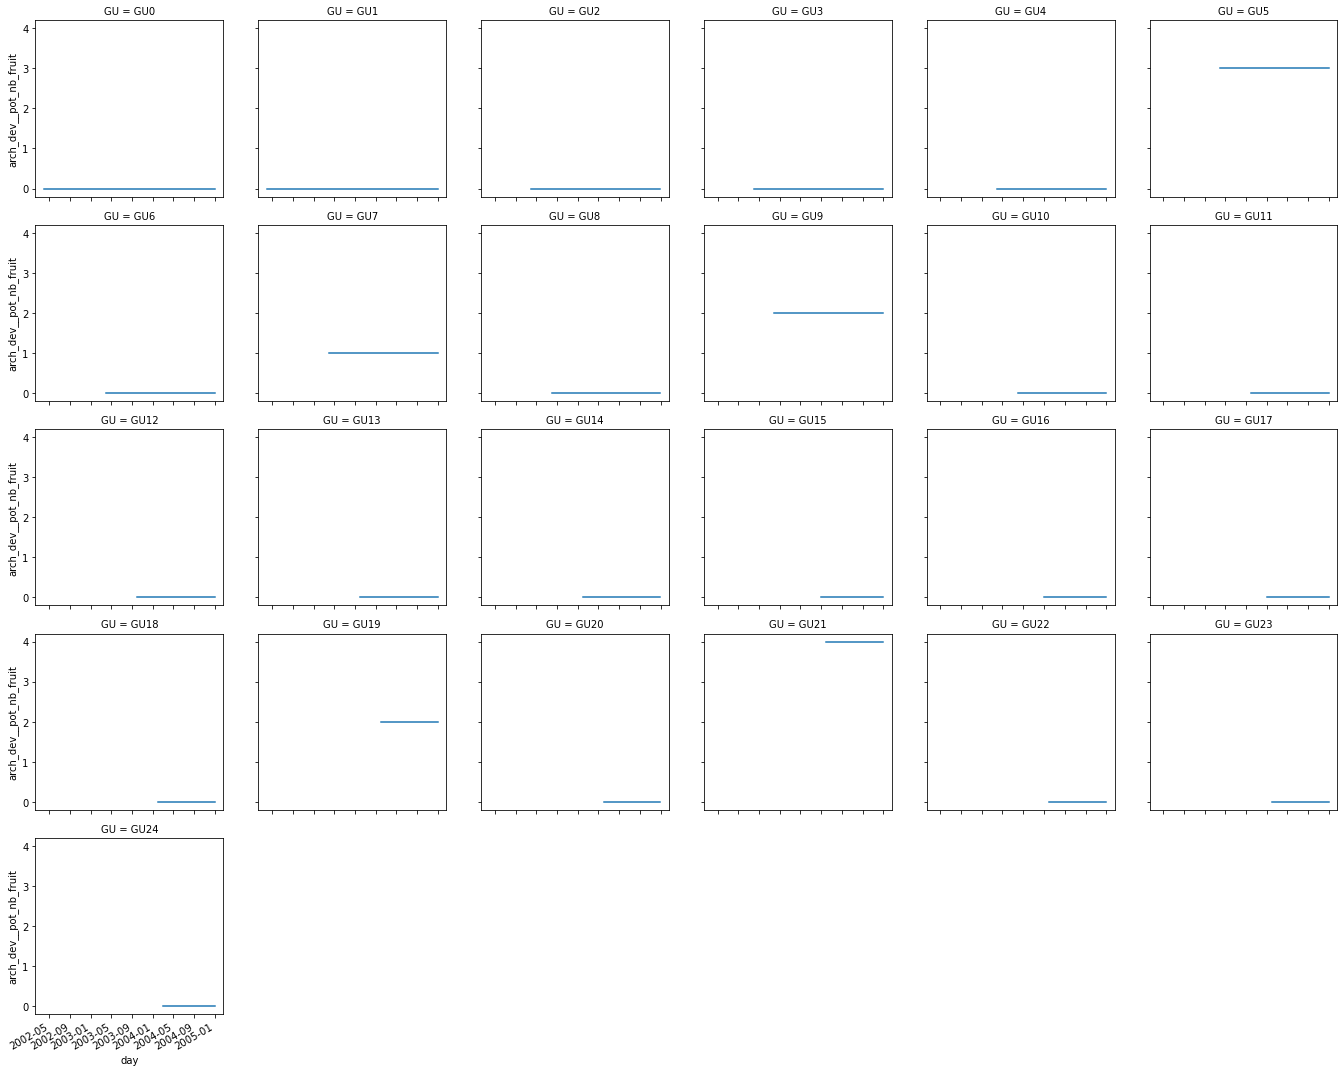

In [34]:
ds_out.arch_dev__pot_nb_fruit.plot(col='GU', col_wrap=6)